# 🧠 Tipos de Agentes en LangChain

En este documento se explican los principales tipos de agentes disponibles en LangChain y otros frameworks LLM, incluyendo sus características, ventajas, desventajas y diferencias clave.

---

## 📋 Tipos de Agentes

### 1. Zero-Shot Agent
- Usa un prompt base sin ejemplos (zero-shot).
- Elige herramientas a partir de la descripción.
- No planifica ni razona explícitamente.
- Útil para tareas simples.

### 2. ReAct Agent (Reason + Act)
- Usa el patrón "Pensamiento → Acción → Observación".
- Razonamiento explícito en cadena.
- Adecuado para tareas multistep.
- Necesita parsers para interpretar el texto del LLM.

### 3. Conversational Agent
- Mantiene memoria conversacional.
- Ideal para asistentes multiturno.
- Compatible con herramientas y razonamiento.

### 4. Plan-and-Execute Agent
- Divide el proceso en dos etapas: planificación y ejecución.
- Bueno para tareas estructuradas o largas.
- Usa un planner (estrategia) y un executor (acción).

### 5. Tool-Calling Agent (Function Calling / Tools API)
- Usa APIs nativas como OpenAI Function Calling.
- El modelo devuelve JSON estructurado con qué herramienta usar.
- Muy robusto y simple de ejecutar.
- Razonamiento implícito.

### 6. Self-Reflective Agent
- Revisa su propia salida y puede corregir errores.
- Añade una segunda etapa de verificación.
- Útil para tareas sensibles o que requieran precisión.

---

## 📊 Comparativa de Agentes

| Tipo de agente           | ¿Usa ejemplos? | ¿Multistep? | ¿Conversacional? | ¿Tool Calling? | ¿Planificación? | ¿Reflexión? |
|--------------------------|----------------|-------------|------------------|----------------|------------------|-------------|
| Zero-Shot Agent          | ❌ No          | ❌ No        | ❌ No             | ✅ Opcional     | ❌ No             | ❌ No        |
| ReAct Agent              | ✅ Sí          | ✅ Sí        | Opcional          | ✅ Sí           | Parcial           | ❌ No        |
| Conversational Agent     | ✅ Sí          | ✅ Sí        | ✅ Sí             | ✅ Sí           | ❌ No             | ❌ No        |
| Plan-and-Execute Agent   | ✅ Sí          | ✅ Sí        | Opcional          | ✅ Sí           | ✅ Sí             | ❌ No        |
| Tool-Calling Agent       | ❌/✅           | ✅ Sí        | ✅ Sí             | ✅✅ Nativo      | ❌ No             | ❌ No        |
| Self-Reflective Agent    | ✅ Sí          | ✅ Sí        | Opcional          | ✅ Sí           | ✅ Parcial        | ✅ Sí        |

---

## 📝 Recomendaciones de uso

| Escenario                                         | Agente recomendado        |
|--------------------------------------------------|---------------------------|
| Tareas simples con pocas herramientas            | Zero-Shot Agent           |
| Tareas multistep con razonamiento visible        | ReAct Agent               |
| Asistentes conversacionales inteligentes         | Conversational Agent      |
| Automatización de flujos con pasos definidos     | Plan-and-Execute Agent    |
| Integraciones robustas con APIs externas         | Tool-Calling Agent        |
| Validación de resultados y control de errores    | Self-Reflective Agent     |

---

#### Importamos todas las librerías necesarias

In [ ]:
import re
import numexpr
import datetime
from ddgs import DDGS
from dotenv import load_dotenv
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.agents import  Tool, AgentExecutor, AgentType, initialize_agent, create_react_agent, create_tool_calling_agent
from langchain_experimental.plan_and_execute import PlanAndExecute, load_agent_executor, load_chat_planner

#### Cargar variables de entorno desde .env si existe

In [ ]:
load_dotenv()

#### Inicializamos el modelo LLM y las herramientas

In [ ]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [ ]:
search = DDGS()

In [ ]:
def calculadora(expression: str) -> str:
    try:
        expr = expression.lower().replace("x", "*").replace(",", "")
        if not re.match(r"^[0-9\.\+\-\*\/\(\)\s]+$", expr):
            return "Expresión no válida."
        return str(numexpr.evaluate(expr))
    except Exception as e:
        return f"Error en la expresión: {e}"

## 1. Zero-Shot Agent

#### Ejemplo 1: Agente básico con búsqueda web y calculadora (DuckDuckGo)

In [ ]:
tools = [
    Tool(name="buscar_en_la_web", func=search.text, description="Busca información actualizada en la web"),
    Tool(name="calculadora", func=calculadora, description="Realiza cálculos simples")
]

agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)
agent.invoke("Busca el precio actual del Bitcoin y multiplícalo por 2")

#### Ejemplo 2: Añadir herramienta de fecha y hora

In [ ]:
def obtener_fecha_hora(_: str = "") -> str:
    return datetime.datetime.now().strftime("Fecha y hora actual: %Y-%m-%d %H:%M:%S")

tools.append(Tool(name="fecha_y_hora", func=obtener_fecha_hora, description="Devuelve la fecha y hora actual"))
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)
agent.invoke("Dime la fecha y hora actual en España")

#### Ejemplo 3: Planificación de múltiples pasos

In [ ]:
agent.invoke("Busca la capital de Francia, dime la fecha y hora actual y calcula 5*7")

#### Ejemplo 4: Herramienta personalizada (traductor simulado)

In [ ]:
def traductor_mock(texto: str) -> str:
    return f"Traducción simulada al inglés: {texto} (traducido)"

tools.append(Tool(name="traductor", func=traductor_mock, description="Traduce texto de español a inglés (simulado)"))
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)
agent.invoke("Traduce 'Hola mundo, hoy aprendemos LangChain' al inglés")

## 2. ReAct Agent

In [ ]:
prompt = hub.pull("hwchase17/react")
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

response = agent_executor.invoke({
    "input": "Busca la capital de Francia, dime la fecha y hora actual y calcula 5*7"
})

print(f"Respuesta ReAct: {response['output']}")

## 3. Conversational Agent

In [ ]:
memory = ConversationBufferMemory(memory_key="chat_history")
agent_chain = initialize_agent(
    tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, memory=memory, verbose=True
)
agent_chain.invoke("¿Cuál es la capital de Francia?")
agent_chain.invoke("¿Cuál fue mi pregunta anterior?")

## 4. Plan-and-Execute Agent

In [ ]:
planner = load_chat_planner(llm)
executor = load_agent_executor(llm, tools, verbose=True)

plan_and_execute = PlanAndExecute(planner=planner, executor=executor)
plan_and_execute.invoke("Busca la temperatura en Madrid del dia de hoy y luego dime qué ropa debo llevar para salir de casa")

## 5. Tool-Calling Agent

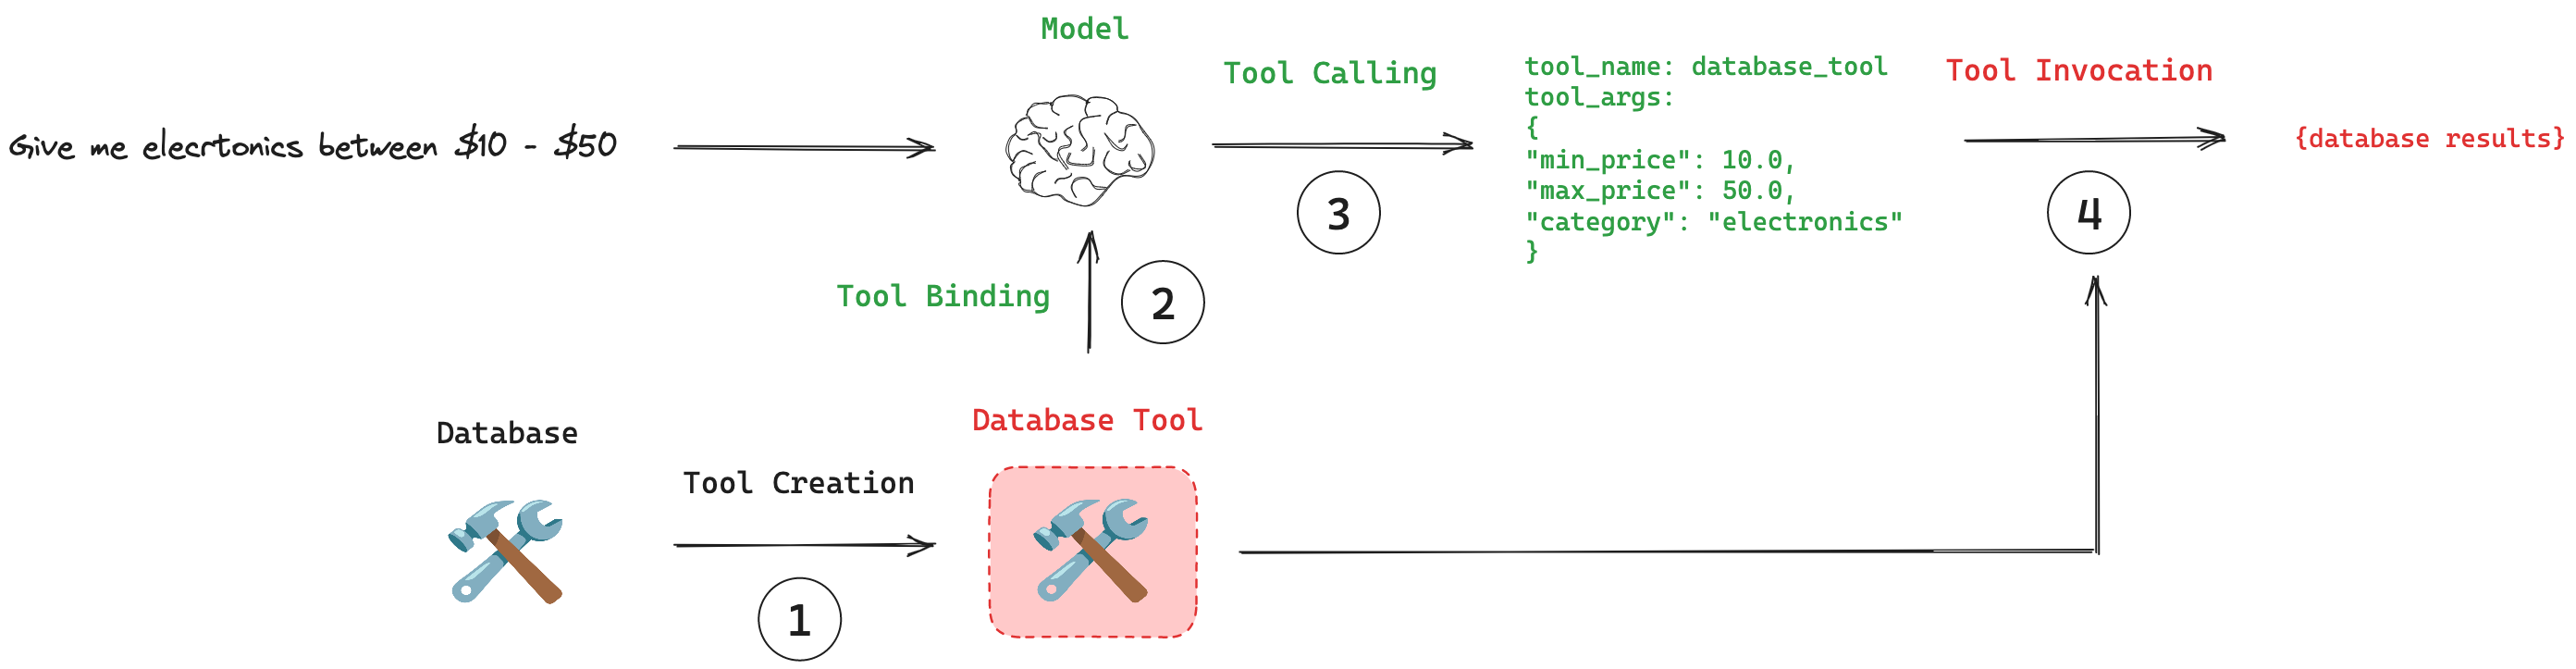

In [ ]:
prompt = hub.pull("hwchase17/openai-tools-agent")
agent = create_tool_calling_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [ ]:
preguntas = [
    "¿Cuál es el clima en Tokio?",
    "Calcula 15 * 8 + 20",
    "Cuantos minutos faltan para el estreno de Avatar 3?",
]

for pregunta in preguntas:
    print(f"\n Pregunta: {pregunta}")
    response = agent_executor.invoke({"input": pregunta})
    print(f" Respuesta: {response['output']}")

# 🤖 Diferencia entre ReAct Agent y Tool-Calling Agent en LangChain

En los sistemas basados en LLM como LangChain, existen diferentes tipos de agentes que pueden usar herramientas externas para completar tareas. Aquí explicamos las diferencias clave entre dos de los más usados: **ReAct Agent** y **Tool-Calling Agent**.

---

## 🧠 ReAct Agent (Reason + Act)

### Características:
- Usa el patrón **"Pensamiento → Acción → Observación"**.
- Razonamiento explícito con texto tipo `Thought`, `Action`, `Observation`.
- El modelo **elige herramientas** mediante texto natural, y LangChain **interpreta** las acciones usando parsers.
- Flexible para tareas complejas y multistep.

### Ejemplo:
```
Thought: Necesito calcular 12 * 9.
Action: Calculator("12 * 9")
Observation: 108
Thought: La respuesta es 108.
```

### ✅ Ventajas:
- Permite razonamiento en varios pasos.
- Útil para debugging y seguimiento detallado del flujo de decisiones.

### ⚠️ Desventajas:
- Requiere prompts más complejos.
- Más propenso a errores de formato si el modelo no sigue bien las instrucciones.

---

## ⚙️ Tool-Calling Agent (Function Calling / Tools API)

### Características:
- Usa la funcionalidad de **function calling** nativa en modelos como GPT-4.
- El modelo devuelve un **JSON estructurado** indicando qué función ejecutar.
- LangChain ejecuta directamente la herramienta sin necesidad de parsing textual.

### Ejemplo de salida del modelo:
```json
{
  "name": "Calculator",
  "arguments": { "expression": "12 * 9" }
}
```

### ✅ Ventajas:
- Muy robusto: menos errores de interpretación.
- Más simple de implementar en producción.

### ⚠️ Desventajas:
- El razonamiento es **implícito** (no hay "thought" intermedios).
- Menos control sobre cómo el modelo decide usar la herramienta.

---

## 📊 Comparativa rápida

| Aspecto                   | ReAct Agent                         | Tool-Calling Agent                      |
|---------------------------|--------------------------------------|-----------------------------------------|
| Selección de herramienta  | Texto natural + parser               | JSON estructurado (function calling)    |
| Razonamiento explícito    | ✅ Sí                                | ❌ No                                   |
| Robustez                  | ⚠️ Propenso a errores de formato      | ✅ Muy robusto                          |
| Complejidad de implementación | Alta                             | Baja                                    |
| Soporte multistep         | ✅ Muy bueno                         | ✅ Bueno, pero menos explícito          |

---

## 📝 ¿Cuándo usar cada uno?

| Necesidad                          | Usa este agente          |
|-----------------------------------|--------------------------|
| Tareas complejas paso a paso      | ReAct Agent              |
| Alta fiabilidad en producción     | Tool-Calling Agent       |
| Depuración y análisis del razonamiento | ReAct Agent          |
| Integración limpia con APIs       | Tool-Calling Agent       |